<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/HR_cHsJcbMpL-g)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
# DATA_PATH = ''
# %matplotlib inline

# # For Google Colab only:
# import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
# #from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
# from google.colab import drive
# drive.mount('/content/gdrive')

# DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

In [2]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [3]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [4]:
#1. Добавить ко всем описаниям символы начала и конца предложения

start_symbol = '_START_'
end_symbol = '_END_'

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["_START_"]+sentence.split(' ')+["_END_"]

In [5]:
#2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)

from collections import Counter
word_counts = Counter()

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i][1:-1]:
            word_counts[word] += 1
            
x = 5

unknown_symbol = '_UNK_'
padding_symbol = '_PAD_'

vocab  = [unknown_symbol, start_symbol, end_symbol, padding_symbol]
vocab += [k for k, v in word_counts.items() if v >= x if k not in vocab]
n_tokens = len(vocab)

In [6]:
#3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
#4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. 
eos_ix = word_to_index[end_symbol]
unk_ix = word_to_index[unknown_symbol]
pad_ix = word_to_index[padding_symbol]

def word_to_matrix(sequences, max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.ones((len(sequences), max_len), dtype='int32') * pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
captions[42]

[['_START_',
  'a',
  'small',
  'bed',
  'laying',
  'on',
  'top',
  'of',
  'a',
  'table',
  '.',
  '_END_'],
 ['_START_',
  'a',
  'bird',
  'stting',
  'on',
  'what',
  'appears',
  'to',
  'be',
  'a',
  'piece',
  'of',
  'machinery',
  '.',
  '_END_'],
 ['_START_',
  'small',
  'bird',
  'with',
  'fluffy',
  'feathers',
  'sitting',
  'in',
  'nest',
  '_END_'],
 ['_START_',
  'a',
  'small',
  'bird',
  'with',
  'its',
  'head',
  'pulled',
  'back',
  '_END_'],
 ['_START_',
  'a',
  'newborn',
  'baby',
  'bird',
  'sitting',
  'quietly',
  'by',
  'itself',
  '_END_']]

In [9]:
word_to_matrix(captions[42],)

array([[  1,  24, 131, 158,  60,  35,  77,  14,  24,  71,  12,   2,   3,
          3,   3],
       [  1,  24, 447, 523,  35, 524, 525, 117, 516,  24, 526,  14, 323,
         12,   2],
       [  1, 131, 447,  58, 527, 528, 140,   6, 529,   2,   3,   3,   3,
          3,   3],
       [  1,  24, 131, 447,  58, 188, 274, 530, 382,   2,   3,   3,   3,
          3,   3],
       [  1,  24, 531, 189, 447, 140, 532, 163, 533,   2,   3,   3,   3,
          3,   3]], dtype=int32)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [12]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        super(self.__class__, self).__init__()
        
        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units).to(device)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units).to(device)
        
        # вот теперь recurrent part

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, 64, padding_idx = pad_ix).to(device)
            
        # lstm: настакайте LSTM-ок (1 или более, но не надо сразу пихать больше двух, замечаетесь ждать).
        self.lstm = nn.LSTM(batch_first = True, input_size = 64, hidden_size = lstm_units).to(device)
#         self.lstm2 = nn.LSTM(batch_first = True, input_size = 256, hidden_size = lstm_units).to(device)
            
        # ну и линейный слой для получения логитов
        self.logits = nn.Linear(lstm_units, n_tokens).to(device)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # 
        captions_emb = self.emb(captions_ix)
        
        # применим LSTM:
        # 1. инициализируем lstm state с помощью initial_* (сверху)
        # 2. скормим LSTM captions_emb
        # 3. посчитаем логиты из выхода LSTM
        
        
        lstm_out, (cell_next, hid_next) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None])) # shape: [batch, caption_length, lstm_units]
#         lstm_out, (cell_next, hid_next) = self.lstm2(lstm_out, (cell_next, hid_next)) # shape: [batch, caption_length, lstm_units]
        
       
        logits = self.logits(lstm_out)
        
        return logits        

In [13]:
network = CaptionNet(n_tokens).to(device)

In [14]:
network

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 64, padding_idx=3)
  (lstm): LSTM(64, 256, batch_first=True)
  (logits): Linear(in_features=256, out_features=10403, bias=True)
)

In [15]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    mask = captions_ix_next != pad_ix
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    next_reshaped = captions_ix_next.to(device).view(-1)
    logits_reshaped = logits_for_next.view(-1, logits_for_next.size()[-1])
    
    # compute the loss function between logits_for_next and captions_ix_next
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    cross_entropy = nn.CrossEntropyLoss(reduction = 'none').to(device)
    loss = cross_entropy(logits_reshaped, next_reshaped).view(captions_ix_next.size()[0], captions_ix_next.size()[1]) * mask.float()
    loss = loss.mean(dim = -1).mean(dim = -1).view(-1)
    return loss

In [16]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

Поделим выборку на train/test:

In [17]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [18]:
# batch generator. Можно заменить на свой/переделать этот
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = word_to_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).to(device), torch.tensor(batch_captions_ix, dtype=torch.int64).to(device)
    

In [19]:
generate_batch(img_codes,captions,3)

(tensor([[0.2116, 0.2582, 0.7846,  ..., 0.3192, 0.3284, 0.3076],
         [0.6776, 0.1073, 0.3510,  ..., 0.5342, 0.4623, 0.0999],
         [0.1978, 0.0793, 0.2736,  ..., 0.0258, 0.0724, 0.0205]],
        device='cuda:0'),
 tensor([[   1,   24,  699,   14, 3600, 1113,   24,  438, 2826,    2,    3,    3],
         [   1,   45,  328,  329,   41, 7511,  209,  572,   45,   97,   12,    2],
         [   1,   24,  127,  328,  329,  193,   88,  244, 8903,  425,   12,    2]],
        device='cuda:0'))

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [20]:
batch_size = 128 * 3
n_epochs = 100
n_batches_per_epoch = 400
n_validation_batches = 10

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
from tqdm import tnrange, tqdm, trange, tqdm_notebook
from IPython import display
import time


train_losses = []
val_losses = []

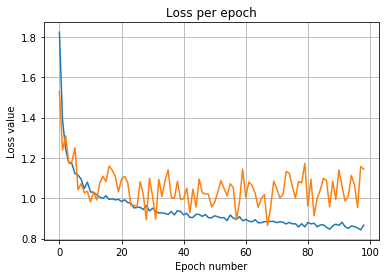


100/100 epoch in process...
Training:


100%|██████████| 100/100 [42:50<00:00, 24.99s/it]

Finished!


In [23]:
for epoch in trange(n_epochs):
    
    display.clear_output(wait = True)
    
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('Epoch number')
    plt.ylabel('Loss value')
    # plt.ylim([0, 20000])
    plt.title('Loss per epoch')
    plt.grid(True)
    plt.show()
    
    print()
    print('{}/{} epoch in process...'.format(epoch+1, n_epochs))
    
    print("Training:")
    train_loss = 0
    network.train(True)
    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        loss_t.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss_t.cpu().data.numpy()[0]
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.cpu().data.numpy()[0]
    val_loss /= n_validation_batches
      
    train_losses.append(train_loss)
    val_losses.append(val_loss)

print("Finished!")

## Inseption и получение результатов


In [24]:
# загружаем inseption
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Сгенерируем описание

In [25]:
def generate_caption(image, caption_prefix=("_START_",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)
        
        vectors_neck = vectors_neck.to(device)

        for _ in range(max_len):
            # представить в виде матрицы
            prefix_ix = word_to_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).to(device)
            # получаем логиты из RNN-ки
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            # переводим их в вероятности
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # опционально

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            # RNN-ка сгенерила символ конца предложения, расходимся
            if next_word == "_END_":
                break
            
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [26]:
from matplotlib import pyplot as plt
from PIL import Image
# from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

--2020-02-20 16:08:16--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.84.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.84.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 105,40K  --.-KB/s    in 0,08s   

2020-02-20 16:08:16 (1,26 MB/s) - ‘img.jpg’ saved [107928/107928]



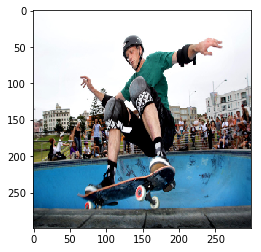

In [27]:
plt.imshow(img)

In [28]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a skateboarder is doing a trick on a rail .
a man riding a skateboard up the side of a ramp .
a man is doing a trick on a skateboard .
a man on a skateboard jumping over a metal rail .
a skateboarder is doing a trick on the edge of a ramp .
a skateboarder is in mid air on a ramp .
a man riding a skateboard up the side of a ramp .
a skateboarder is doing a trick in the air .
a skateboarder is jumping over a rail .
a skateboarder is doing a trick in the air .


--2020-02-20 16:08:18--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2020-02-20 16:08:18--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img2.jpg’

img2.jpg            100%[===================>] 104,37K   274KB/s    in 0,4s    

2020-02-20 16:08:19 (274 KB/s) - ‘img2.jpg’ saved [106870/106870]



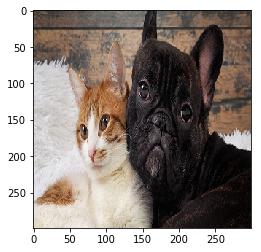

a black cat with a red collar and black collar .
a black cat with a tag on its head .
a black and white cat is sitting on a couch .
a black cat is sitting on a black chair .
a black cat with its tongue out on a chair .
a black cat with a tag on its head .
a black cat with a red collar sitting on a chair .
a black cat is sitting on a black chair .
a black cat with a red collar on its head .
a black cat with a tag on its head .


In [29]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img2.jpg
img = plt.imread('img2.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2020-02-20 16:08:20--  https://s.yimg.com/uu/api/res/1.2/DdytqdFTgtQuxVrHLDdmjQ--~B/aD03MTY7dz0xMDgwO3NtPTE7YXBwaWQ9eXRhY2h5b24-/https://media-mbst-pub-ue1.s3.amazonaws.com/creatr-uploaded-images/2019-11/7b5b5330-112b-11ea-a77f-7c019be7ecae
Resolving s.yimg.com (s.yimg.com)... 87.248.118.22, 87.248.118.23, 2a00:1288:80:800::7001, ...
Connecting to s.yimg.com (s.yimg.com)|87.248.118.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87020 (85K) [image/jpeg]
Saving to: ‘img3.jpg’

img3.jpg            100%[===================>]  84,98K  --.-KB/s    in 0,09s   

2020-02-20 16:08:20 (905 KB/s) - ‘img3.jpg’ saved [87020/87020]



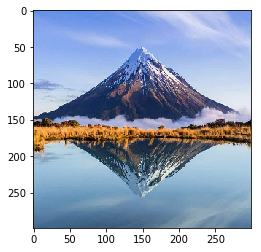

a man sitting on a bench with a large mountain in the background .
a man on a surfboard is riding a wave .
a man sitting on a bench with a large mountain .
a man sitting on a rock with a mountain in the background .
a man sitting on a rock with a mountain in the background .
a man on a green field with a white and blue striped object .
a man sitting on a bench with a large mountain .
a man on a snow board rides a big wave
a man sitting on a bench with a large mountain .
a man sitting on a rock with a mountain in the background .


In [30]:
!wget https://s.yimg.com/uu/api/res/1.2/DdytqdFTgtQuxVrHLDdmjQ--~B/aD03MTY7dz0xMDgwO3NtPTE7YXBwaWQ9eXRhY2h5b24-/https://media-mbst-pub-ue1.s3.amazonaws.com/creatr-uploaded-images/2019-11/7b5b5330-112b-11ea-a77f-7c019be7ecae -O img3.jpg
img = plt.imread('img3.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-02-20 16:08:22--  https://cnet2.cbsistatic.com/img/hEHxbI1Pphmvod56-B5ATDBmlwY=/0x0:2438x1440/980x551/2019/10/16/db85bfaa-b206-4e8e-a468-d878d80d46cc/newc-yongqing-bao-wildlife-photographer-of-the-year.jpg
Resolving cnet2.cbsistatic.com (cnet2.cbsistatic.com)... 151.101.85.188, 2a04:4e42:14::444
Connecting to cnet2.cbsistatic.com (cnet2.cbsistatic.com)|151.101.85.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88321 (86K) [image/jpeg]
Saving to: ‘img4.jpg’

img4.jpg            100%[===================>]  86,25K  --.-KB/s    in 0,08s   

2020-02-20 16:08:22 (1,11 MB/s) - ‘img4.jpg’ saved [88321/88321]



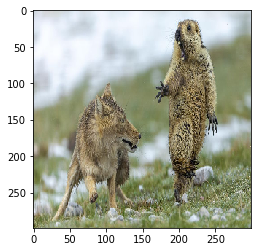

a brown bear standing in front of a tree .
a brown bear standing in a forest .
a brown bear standing next to a tree .
a brown bear standing next to a brown dog .
a brown bear standing next to a tree .
a brown bear standing next to a tree .
a brown bear standing in front of a tree .
a brown bear standing next to a brown horse .
a brown bear standing in front of a tree .
a brown bear standing next to a brown horse .


In [31]:
!wget https://cnet2.cbsistatic.com/img/hEHxbI1Pphmvod56-B5ATDBmlwY=/0x0:2438x1440/980x551/2019/10/16/db85bfaa-b206-4e8e-a468-d878d80d46cc/newc-yongqing-bao-wildlife-photographer-of-the-year.jpg -O img4.jpg
img = plt.imread('img4.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [32]:
# !wget  -O img5.jpg
# img = plt.imread('img5.jpg')
# # img = imresize(img, (299, 299)).astype('float32') / 255.
# img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

# plt.imshow(img)
# plt.show()

# for i in range(10):
#     print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-02-20 16:08:23--  https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR8oUC4JF3DtfhyNPUkl-iu20mcAOQ79D_5MA8KLGnDKm6chqHe
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 173.194.222.138, 173.194.222.113, 173.194.222.139, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|173.194.222.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6472 (6,3K) [image/jpeg]
Saving to: ‘img6.jpg’

img6.jpg            100%[===================>]   6,32K  --.-KB/s    in 0s      

2020-02-20 16:08:23 (28,9 MB/s) - ‘img6.jpg’ saved [6472/6472]



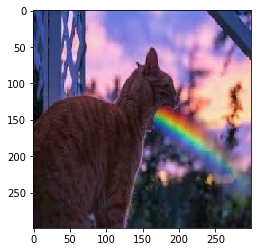

a close up of a cat on a tree
a close up of a cat on a bench
a close up of a cat on a bench
a close up of a cat on a tree
a close up of a cat on a red chair
a close up of a cat on a red chair
a close up of a cat on a bench
a close up of a cat on a tree
a close up of a cat on a bench
a close up of a cat on a bench


In [33]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR8oUC4JF3DtfhyNPUkl-iu20mcAOQ79D_5MA8KLGnDKm6chqHe -O img6.jpg
img = plt.imread('img6.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-02-20 16:08:25--  https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQX33fzHI8MVQZauFt6B2pEM341YYJPIrD_PgpSK7d2Rnh2urjg
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 173.194.222.101, 173.194.222.102, 173.194.222.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|173.194.222.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4971 (4,9K) [image/jpeg]
Saving to: ‘img7.jpg’

img7.jpg            100%[===================>]   4,85K  --.-KB/s    in 0s      

2020-02-20 16:08:25 (24,2 MB/s) - ‘img7.jpg’ saved [4971/4971]



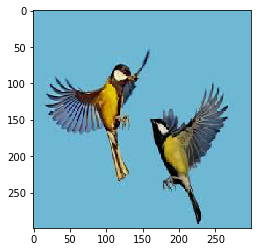

a colorful bird flying in the sky with a bunch of birds .
a colorful bird flying in the sky above a tree .
a colorful bird flying in the sky above a tree .
a colorful bird flying in the air with a blue sky in the background .
a colorful bird flying in the sky above a tree .
a bird is perched on a branch in a tree .
a colorful bird flying in the sky with a bunch of birds on it .
a colorful bird flying in the air with a bunch of birds on it .
a bird is perched on a branch in a tree .
a colorful bird flying in the air with wings outstretched .


In [34]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQX33fzHI8MVQZauFt6B2pEM341YYJPIrD_PgpSK7d2Rnh2urjg -O img7.jpg
img = plt.imread('img7.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-02-20 16:08:26--  https://www.rd.com/wp-content/uploads/2018/12/50-Funny-Animal-Pictures-That-You-Need-In-Your-Life-2.jpg
Resolving www.rd.com (www.rd.com)... 104.17.127.66, 104.16.183.30, 2606:4700::6811:7f42, ...
Connecting to www.rd.com (www.rd.com)|104.17.127.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111217 (109K) [image/jpeg]
Saving to: ‘img8.jpg’

img8.jpg            100%[===================>] 108,61K  --.-KB/s    in 0,03s   

2020-02-20 16:08:26 (3,70 MB/s) - ‘img8.jpg’ saved [111217/111217]



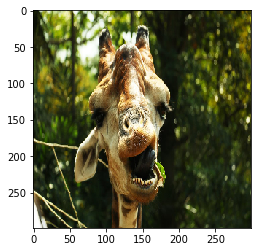

a giraffe is standing in the grass with trees in the background .
a giraffe eating leaves from a tree .
a giraffe is standing in the woods with a tree .
a giraffe eating a leaf from a tree .
a giraffe standing next to a tree in a forest .
a giraffe is standing in the grass with trees in the background .
a giraffe standing next to a tree in a forest .
a giraffe eating leaves from a tree .
a giraffe is standing in the woods next to a tree .
a giraffe is standing in the woods with a tree .


In [35]:
!wget https://www.rd.com/wp-content/uploads/2018/12/50-Funny-Animal-Pictures-That-You-Need-In-Your-Life-2.jpg -O img8.jpg
img = plt.imread('img8.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-02-20 16:08:27--  https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQscu8GnesXGvdlMQ1NdLRHpLoxv-1lbe42Nm0XUtxJRhHo4wnM
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 173.194.222.101, 173.194.222.102, 173.194.222.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|173.194.222.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5884 (5,7K) [image/jpeg]
Saving to: ‘img9.jpg’

img9.jpg            100%[===================>]   5,75K  --.-KB/s    in 0s      

2020-02-20 16:08:27 (53,0 MB/s) - ‘img9.jpg’ saved [5884/5884]



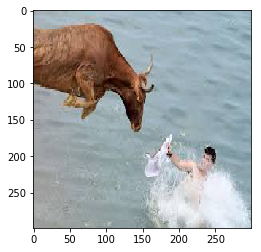

a brown cow laying on top of a sandy beach .
a brown cow laying on top of a sandy beach .
a brown cow laying on top of a beach .
a dog is laying on the ground with a dog .
a dog laying on the ground with a dog in his mouth
a brown cow laying on the ground with a dog .
a brown cow laying on top of a beach .
a brown cow laying on top of a beach .
a brown cow laying on top of a sandy beach .
a brown cow laying on top of a sandy beach .


In [36]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQscu8GnesXGvdlMQ1NdLRHpLoxv-1lbe42Nm0XUtxJRhHo4wnM -O img9.jpg
img = plt.imread('img9.jpg')
# img = imresize(img, (299, 299)).astype('float32') / 255.
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [39]:
torch.save(network, 'model100ep384bs.pkl')

/home/agekyan/.conda/envs/psheenv/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CaptionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
